# Running Analysis
## Garmin ForeRunner45 data

### Imports

In [1598]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sns

### Loading Data

In [1599]:
def load_data(loc: str) -> pd.DataFrame:
    """
    param file: the name of the file with the running data
    return: dataframe with the data
    """
    return pd.read_csv(loc)
location = r"running_activities.csv"
data = load_data(location)
data.rename(columns = {"Time" : "Duration", "Place": "Location"}, inplace=True)
data.head()

,Activity Type,Date,Distance,Calories,Duration,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,...,Total Ascent,Total Descent,Avg Stride Length,Moving Time,Elapsed Time,Min Elevation,Max Elevation,Effort,Self Feel,Location
0,Running,12/09/2022 21:00,7.01,464,0:41:59,0,0,169,192,6:00,...,31,55,0.99,0:41:54,0:41:59,50,80,9,3,Ein Vered
1,Running,08/09/2022 20:02,5.00,329,0:28:19,0,0,168,176,5:39,...,38,34,1.05,0:28:18,0:28:24,55,80,8,5,Ein Vered
2,Running,05/09/2022 20:50,7.01,460,0:40:02,0,0,169,175,5:43,...,34,57,1.04,0:39:56,0:40:02,50,80,8,5,Ein Vered
3,Running,03/09/2022 20:10,7.00,464,0:41:36,0,0,170,182,5:56,...,36,53,0.99,0:41:34,0:41:36,52,78,7,5,Ein Vered
4,Running,01/09/2022 20:42,5.01,331,0:28:57,0,0,167,175,5:47,...,19,35,1.03,0:28:50,0:28:57,50,79,8,5,Ein Vered


### Filling empty cells with the average of it's column

In [1600]:
for empty_col in data.columns:
    data.loc[data[empty_col] == "--", empty_col] = 0

# columns with empty data
cols_to_numeric = ["Avg HR", "Max HR", "Total Ascent", "Total Descent", "Min Elevation", "Max Elevation", "Effort", "Self Feel"]
for col in cols_to_numeric:
    data[col] = pd.to_numeric(data[col])
    min_value = round(data[col].mean())
    data.loc[data[col] == 0, col] = min_value

### Data pre-processing

#### filtering all the five km runs

In [1601]:
epsilon_of_five = 0.1
five_km_runs = data.loc[(data["Distance"] >= 5-epsilon_of_five) & (data["Distance"] <= 5+epsilon_of_five)]
five_km_runs = five_km_runs.reset_index(drop=True)
five_km_runs.describe()

,Distance,Calories,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Total Ascent,Total Descent,Avg Stride Length,Min Elevation,Max Elevation,Effort,Self Feel
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,5.005568,343.090909,156.079545,171.738636,166.170455,177.886364,45.681818,48.170455,1.047727,192.375000,225.000000,7.102273,3.977273
std,0.011127,16.713706,21.461659,21.575046,2.496994,10.033773,49.222120,40.275551,0.065526,102.622544,106.730836,2.045684,1.028080
min,5.000000,316.000000,122.000000,137.000000,157.000000,169.000000,9.000000,22.000000,0.700000,28.000000,71.000000,3.000000,1.000000
25%,5.000000,329.000000,122.000000,137.000000,165.000000,173.000000,25.750000,33.000000,1.040000,53.750000,80.000000,5.000000,3.000000
50%,5.000000,341.500000,167.000000,183.000000,167.000000,176.000000,33.500000,38.000000,1.060000,269.000000,293.500000,7.000000,4.000000
75%,5.010000,353.500000,171.250000,186.000000,168.000000,178.000000,40.000000,43.000000,1.080000,270.000000,302.250000,9.000000,5.000000
max,5.090000,396.000000,179.000000,195.000000,170.000000,227.000000,264.000000,229.000000,1.150000,285.000000,350.000000,10.000000,5.000000


### Side Functions

#### Converting functions

In [1602]:
def pace_as_number(pace: str) -> float:
    """
    param pace: run pace as string
    return: run pace as a float, for calc avg. speed
    """
    m = float(pace.split(sep=":")[0])
    sec = float(pace.split(sep=":")[1]) / 100
    return m+sec

def time_as_number(df: pd.DataFrame) -> list:
    """
    param df: dataframe full of running data
    return: a list of numbers that represent the hour as in form of <Hour.Part of the hour>
    """
    lst = []
    for time in df["Time"]:
        lst.append(time.hour + (time.minute / 60))
    return lst

def number_as_time(t: float) -> str:
    """
    param t: float that represents an hour
    return: the string of that hour
    """
    h = int(t)
    m = int(round((t-h) * 60, 0))
    if m==0:
        return str(h) + ":" + str(m) + "0"
    return str(h) + ":" + str(m)

def duration_to_number(lst: list) -> list:
    """
    param lst: list of durations in the form of a string
    return: list of durations in the form of a number
    """
    new_lst = []
    (sum_h, sum_m, sum_s) = (0, 0, 0)
    for dur in lst:
        h, m, s = dur.split(sep=":")
        sum_h = int(h)
        sum_m = int(m)
        sum_s = int(s)

        if sum_s >= 60:
            sum_s -= 60
            sum_m += 1
        if sum_m >= 60:
            sum_m -= 60
            sum_h += 1

        tot_minutes = sum_h*60 + sum_m + round(float(sum_s/60), 2)
        new_lst.append(tot_minutes)
    return new_lst

def duration_to_string(dur: float) -> str:
    """
    param lst: list of durations in a form of a number
    return: the average duration in the form of a string
    """
    h = int(dur / 60)
    m = int(dur - h*60)
    s = dur - h*60 - m
    total_minutes = h + m + s
    return str(dt.timedelta(minutes=total_minutes)).split(".")[0]

#### Quartiles of a boxplot functions

In [1603]:
def q1_of_season(df: pd.DataFrame) -> float:
    """
    param df: dataframe with runs of a season
    return: a float represents the first quartile of run dispersal
    """
    hours_data = time_as_number(df)
    season_box = plt.boxplot(hours_data, vert=False)
    plt.ioff()
    q1 = [round(min(item.get_xdata()), 1) for item in season_box['boxes']]
    return q1[0]

def q2_of_season(df: pd.DataFrame) -> float:
    """
    param df: dataframe with runs of a season
    return: a float represents the second quartile of run dispersal
    """
    hours_data = time_as_number(df)
    season_box = plt.boxplot(hours_data, vert=False)
    plt.ioff()
    q2 = [round(item.get_xdata()[0], 1) for item in season_box['medians']]
    return q2[0]

def q3_of_season(df: pd.DataFrame) -> float:
    """
    param df: dataframe with runs of a season
    return: a float represents the third quartile of run dispersal
    """
    hours_data = time_as_number(df)
    season_box = plt.boxplot(hours_data, vert=False)
    plt.ioff()
    q3 = [round(max(item.get_xdata()), 1) for item in season_box['boxes']]
    return q3[0]

#### Speed functions

In [1604]:
def scatter_speed_per_hour(df: pd.DataFrame):
    """
    param df: dataframe of runs
    return: scatter plot of the runs with speed-hour correlation
    """
    hours = time_as_number(df)
    speeds = df["Avg Speed"]
    new_df = pd.DataFrame(columns=["Time", "Speed"])
    new_df["Hour"] = hours
    new_df["Speed"] = speeds
    sns.lmplot(x="Hour", y = "Speed", data = new_df)
    plt.show()

def avg_speed_for_hour_range(df: pd.DataFrame):
    """
    param df: dataframe of runs
    return: a table of average speed per range of hours
    """
    cols_build = ["Hour Range", "Start Hour", "End Hour", "Avg Speed", "Runs Count"]
    new_table = pd.DataFrame(columns=cols_build)

    list_of_hours = [int(t) for t in time_as_number(df)]
    list_of_hours = sorted(list(dict.fromkeys(list_of_hours)))
    new_table["Start Hour"] = list_of_hours
    new_table["End Hour"] = [h+1 for h in list_of_hours]
    new_table["Hour Range"] = [str(h) + "-" + str(h+1) for h in list_of_hours]
    new_table[["Runs Count", "Avg Speed"]] = 0 # initializing

    for runtime in df["Time"]:
        new_table.loc[new_table["Start Hour"] == runtime.hour, "Runs Count"] += 1
        new_table.loc[new_table["Start Hour"] == runtime.hour, "Avg Speed"] += df["Avg Speed"].apply(np.sum)
    new_table["Avg Speed"] = new_table["Avg Speed"] / new_table["Runs Count"]
    print(new_table[new_table.columns.difference(["Start Hour", "End Hour"])].sort_values(by="Avg Speed", ascending=False).to_string(index=False))

def avg_speed_per_day(df: pd.DataFrame):
    """
    param df: dataframe of runs
    return: prints a dataframe of average speed per day
    """
    cols_list = ["Day", "Avg Speed", "Runs Count"]
    week_days = {"Sunday": 6, "Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, "Friday": 4, "Saturday": 5}
    table = pd.DataFrame(columns=cols_list)

    # initializing
    table["Day"] = week_days.keys()
    table[["Avg Speed", "Runs Count"]] = 0

    for day in df["Date"]:
        table.loc[table["Day"] == pd.to_datetime(day).day_name(), "Runs Count"] += 1
        table.loc[table["Day"] == pd.to_datetime(day).day_name(), "Avg Speed"] += df["Avg Speed"].apply(np.sum)
    table["Avg Speed"] = table["Avg Speed"] / table["Runs Count"]
    print(table.to_string(index=False))

def scatter_speed_per_feel(df: pd.DataFrame):
    """
    param df: dataframe of runs
    return: scatter plot of the runs with speed-feel correlation
    """
    feel = pd.to_numeric(df["Self Feel"])
    speeds = df["Avg Speed"]
    new_df = pd.DataFrame(columns=["Self Feel", "Speed"])
    new_df["Self Feel"] = feel
    new_df["Speed"] = speeds
    sns.lmplot(x="Self Feel", y = "Speed", data = new_df)
    plt.show()

def avg_speed_per_location(df: pd.DataFrame):
    """
    param df: dataframe of runs
    return: average speed per running location
    """
    table_columns = ["Location", "Avg Speed", "Avg Run Time", "Run Count"]
    table = pd.DataFrame(columns=table_columns)
    table["Location"] = list(dict.fromkeys(df["Location"]))
    table[[cell for cell in table_columns[1:]]] = 0
    time_table = pd.DataFrame(columns=["Run Time"])
    time_table["Run Time"] = time_as_number(df)
    # summing
    for loc in df["Location"]:
        table.loc[table["Location"] == loc, "Run Count"] += 1
        table.loc[table["Location"] == loc, "Avg Speed"] += df["Avg Speed"].apply(np.sum)
        table.loc[table["Location"] == loc, "Avg Run Time"] += time_table["Run Time"].apply(np.sum)

    # making averages and converting to string
    table["Avg Speed"] = round(table["Avg Speed"] / table["Run Count"], 2)
    table["Avg Run Time"] = round(table["Avg Run Time"] / table["Run Count"], 2)
    for time in table["Avg Run Time"]:
        table.loc[table["Avg Run Time"] == time, "Avg Run Time"] = number_as_time(time)
    print(table.sort_values(by="Avg Speed", ascending=False).to_string(index=False))

def scatter_speed_per_stride(df: pd.DataFrame):
    """
    param df: dataframe of runs
    return: scatter plot of stride per speed
    """
    strides = df["Avg Stride Length"]
    speeds = df["Avg Speed"]
    new_df = pd.DataFrame(columns=["Stride Length", "Speed"])
    new_df["Stride Length"] = strides
    new_df["Speed"] = speeds
    sns.lmplot(x="Stride Length", y = "Speed", data = new_df)
    plt.show()

#### Self Feel functions

In [1605]:
def self_feel_avgs(df: pd.DataFrame):
    """
    param df: dataframe of runs data
    return: prints a new dataframe with a bunch of averages per Self Feel
    """
    avg_cols = ["Self Feel", "Avg Effort", "Avg Duration", "Avg HR", "Avg Speed", "Avg Ascent", "Avg Stride Length", "Run Count"]
    table = pd.DataFrame(columns=avg_cols)
    duration_table = pd.DataFrame(columns=["Duration"])
    table["Self Feel"] = sorted(list(dict.fromkeys(df["Self Feel"])))
    table[[c for c in avg_cols[1:]]] = 0 # initializing
    duration_table["Duration"] = duration_to_number(df["Duration"])
    for sf in df["Self Feel"]:
        table.loc[table["Self Feel"] == sf, "Run Count"] += 1
        table.loc[table["Self Feel"] == sf, "Avg Effort"] += df["Effort"].apply(np.sum)
        table.loc[table["Self Feel"] == sf, "Avg Duration"] += duration_table["Duration"].apply(np.sum)
        table.loc[table["Self Feel"] == sf, "Avg HR"] += df["Avg HR"].apply(np.sum)
        table.loc[table["Self Feel"] == sf, "Avg Ascent"] += df["Total Ascent"].apply(np.sum)
        table.loc[table["Self Feel"] == sf, "Avg Stride Length"] += df["Avg Stride Length"].apply(np.sum)
        table.loc[table["Self Feel"] == sf, "Avg Speed"] += df["Avg Speed"].apply(np.sum)
    # Average
    for colm in table.columns.difference(["Self Feel", "Run Count"]):
        table[colm] = round(table[colm].div(table["Run Count"]), 2)
    for avg_dur in table["Avg Duration"]:
        table.loc[table["Avg Duration"] == avg_dur, "Avg Duration"] = duration_to_string(avg_dur)
    print(table.to_string(index=False))

#### Effort

In [1606]:
def effort_avgs(df: pd.DataFrame):
    """
    param df: dataframe of runs data
    return: prints a new dataframe with a bunch of averages per Effort
    """
    avg_cols = ["Effort", "Avg Self Feel", "Avg Duration", "Avg HR", "Avg Speed", "Avg Ascent", "Avg Stride Length", "Run Count"]
    table = pd.DataFrame(columns=avg_cols)
    duration_table = pd.DataFrame(columns=["Duration"])
    table["Effort"] = sorted(list(dict.fromkeys(df["Effort"])))
    table[[c for c in avg_cols[1:]]] = 0 # initializing
    duration_table["Duration"] = duration_to_number(df["Duration"])
    for sf in df["Effort"]:
        table.loc[table["Effort"] == sf, "Run Count"] += 1
        table.loc[table["Effort"] == sf, "Avg Self Feel"] += df["Self Feel"].apply(np.sum)
        table.loc[table["Effort"] == sf, "Avg Duration"] += duration_table["Duration"].apply(np.sum)
        table.loc[table["Effort"] == sf, "Avg HR"] += df["Avg HR"].apply(np.sum)
        table.loc[table["Effort"] == sf, "Avg Ascent"] += df["Total Ascent"].apply(np.sum)
        table.loc[table["Effort"] == sf, "Avg Stride Length"] += df["Avg Stride Length"].apply(np.sum)
        table.loc[table["Effort"] == sf, "Avg Speed"] += df["Avg Speed"].apply(np.sum)
    # Average
    for colm in table.columns.difference(["Effort", "Run Count"]):
        table[colm] = round(table[colm].div(table["Run Count"]), 2)
    for avg_dur in table["Avg Duration"]:
        table.loc[table["Avg Duration"] == avg_dur, "Avg Duration"] = duration_to_string(avg_dur)
    print(table.to_string(index=False))

### re-Arranging the dataframe

In [1607]:
# Making average speed, form of km/h
average_speeds = [(60/pace_as_number(avg_pace)) for avg_pace in five_km_runs["Avg Pace"]]
five_km_runs["Avg Speed"] = average_speeds

# Dividing the date into two columns, data and time
five_km_runs["Dates"] = pd.to_datetime(five_km_runs["Date"]).dt.date
five_km_runs["Time"] = pd.to_datetime(five_km_runs["Date"]).dt.time
five_km_runs = five_km_runs.drop("Date", axis=1)
five_km_runs.rename(columns = {"Dates" : "Date"}, inplace=True)
cols = list(five_km_runs)

# re-arranging the location of the dataframe
cols.insert(1, cols.pop(cols.index("Date")))
cols.insert(2, cols.pop(cols.index("Time")))
cols.insert(10, cols.pop(cols.index("Avg Speed")))
five_km_runs = five_km_runs.loc[:, cols]

five_km_runs.describe()

,Distance,Calories,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Speed,Total Ascent,Total Descent,Avg Stride Length,Min Elevation,Max Elevation,Effort,Self Feel
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,5.005568,343.090909,156.079545,171.738636,166.170455,177.886364,11.001696,45.681818,48.170455,1.047727,192.375000,225.000000,7.102273,3.977273
std,0.011127,16.713706,21.461659,21.575046,2.496994,10.033773,0.440187,49.222120,40.275551,0.065526,102.622544,106.730836,2.045684,1.028080
min,5.000000,316.000000,122.000000,137.000000,157.000000,169.000000,9.132420,9.000000,22.000000,0.700000,28.000000,71.000000,3.000000,1.000000
25%,5.000000,329.000000,122.000000,137.000000,165.000000,173.000000,10.963917,25.750000,33.000000,1.040000,53.750000,80.000000,5.000000,3.000000
50%,5.000000,341.500000,167.000000,183.000000,167.000000,176.000000,11.100842,33.500000,38.000000,1.060000,269.000000,293.500000,7.000000,4.000000
75%,5.010000,353.500000,171.250000,186.000000,168.000000,178.000000,11.235955,40.000000,43.000000,1.080000,270.000000,302.250000,9.000000,5.000000
max,5.090000,396.000000,179.000000,195.000000,170.000000,227.000000,11.560694,264.000000,229.000000,1.150000,285.000000,350.000000,10.000000,5.000000


#### dividing the runs per season

In [1608]:
summer_months = [5, 6, 7, 8, 9, 10] # Summer = May to October
winter_months = [1, 2, 3, 4, 11, 12] # Winter = November, December and January to April
summer_runs = pd.DataFrame()
winter_runs = pd.DataFrame()
for date in five_km_runs["Date"]:
    if date.month in summer_months:
        summer_runs = pd.concat([summer_runs, five_km_runs[five_km_runs["Date"] == date]], ignore_index=True, axis = 0)
    else:
        winter_runs = pd.concat([winter_runs, five_km_runs[five_km_runs["Date"] == date]], ignore_index=True, axis = 0)

In [1609]:
# Summer runs preview
summer_runs = summer_runs.reset_index(drop=True).sort_values(by="Date")
summer_runs.describe()

,Distance,Calories,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Speed,Total Ascent,Total Descent,Avg Stride Length,Min Elevation,Max Elevation,Effort,Self Feel
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,5.006727,343.581818,151.800000,166.600000,165.854545,178.927273,10.939744,37.727273,42.018182,1.039091,192.745455,222.763636,7.054545,3.854545
std,0.013341,18.708971,23.209513,22.692469,2.676497,12.212402,0.501340,29.627599,26.440353,0.077990,102.560229,105.574612,2.040499,1.095752
min,5.000000,321.000000,122.000000,137.000000,157.000000,169.000000,9.132420,9.000000,22.000000,0.700000,28.000000,73.000000,4.000000,1.000000
25%,5.000000,329.000000,122.000000,137.000000,164.000000,173.000000,10.919026,27.000000,32.500000,1.030000,55.000000,80.000000,5.000000,3.000000
50%,5.000000,336.000000,165.000000,182.000000,167.000000,176.000000,11.070111,35.000000,38.000000,1.060000,269.000000,293.000000,7.000000,4.000000
75%,5.010000,355.000000,171.500000,184.500000,168.000000,179.000000,11.183685,38.500000,42.000000,1.080000,270.500000,302.000000,9.000000,5.000000
max,5.090000,396.000000,179.000000,189.000000,170.000000,227.000000,11.560694,195.000000,182.000000,1.150000,285.000000,328.000000,10.000000,5.000000


In [1610]:
# Winter runs preview
winter_runs = winter_runs.reset_index(drop=True).sort_values(by="Date")
winter_runs.describe()

,Distance,Calories,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Speed,Total Ascent,Total Descent,Avg Stride Length,Min Elevation,Max Elevation,Effort,Self Feel
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,5.003636,342.272727,163.212121,180.303030,166.696970,176.151515,11.104949,58.939394,58.424242,1.062121,191.757576,228.727273,7.181818,4.181818
std,0.005488,12.950079,16.102712,16.599105,2.098881,4.131595,0.291664,69.395578,55.289596,0.032669,104.314138,110.176073,2.083485,0.882275
min,5.000000,316.000000,122.000000,137.000000,162.000000,169.000000,9.708738,15.000000,27.000000,0.950000,40.000000,71.000000,3.000000,1.000000
25%,5.000000,333.000000,165.000000,183.000000,166.000000,175.000000,11.029412,24.000000,33.000000,1.050000,53.000000,79.000000,5.000000,4.000000
50%,5.000000,343.000000,169.000000,185.000000,167.000000,176.000000,11.131725,32.000000,38.000000,1.060000,269.000000,294.000000,8.000000,4.000000
75%,5.010000,353.000000,171.000000,188.000000,168.000000,178.000000,11.235955,46.000000,46.000000,1.080000,269.000000,303.000000,9.000000,5.000000
max,5.020000,363.000000,176.000000,195.000000,170.000000,188.000000,11.494253,264.000000,229.000000,1.130000,274.000000,350.000000,10.000000,5.000000


### Plots

#### Seasons difference

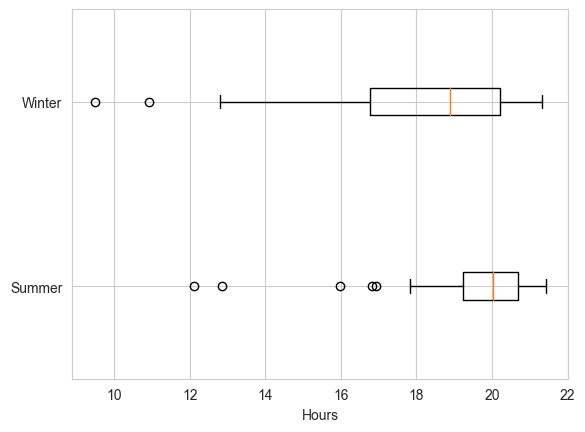

In [1611]:
# presenting both seasons in one diagram
def plot_by_seasons():
    hours_data = [time_as_number(summer_runs), time_as_number(winter_runs)]
    plt.boxplot(hours_data, vert=False)
    plt.yticks([1, 2], ["Summer", "Winter"])
    plt.xlabel("Hours")
plot_by_seasons()
plt.show()

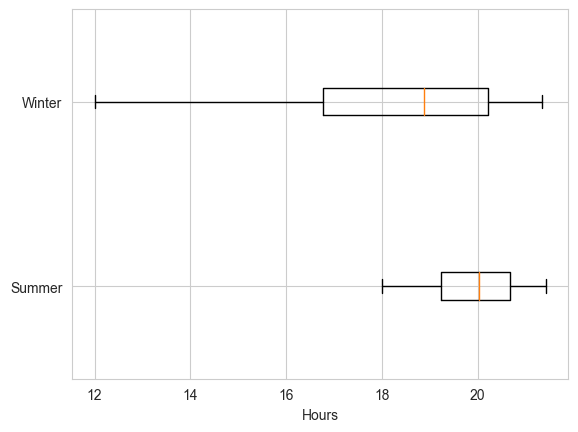

In [1612]:
# normalizing
winter_runs.loc[winter_runs["Time"] < dt.time(hour=12), "Time"] = dt.time(hour=12)
summer_runs.loc[summer_runs["Time"] < dt.time(hour=18), "Time"] = dt.time(hour=18)
plot_by_seasons()
plt.show()

In [1613]:
summer_q1 = q1_of_season(summer_runs)
summer_q2 = q2_of_season(summer_runs)
summer_q3 = q3_of_season(summer_runs)
print("Summer runs are usually between", number_as_time(summer_q1), "and", number_as_time(summer_q3))
print("Summer median is", number_as_time(summer_q2), "\n")

winter_q1 = q1_of_season(winter_runs)
winter_q2 = q2_of_season(winter_runs)
winter_q3 = q3_of_season(winter_runs)
print("Winter runs are usually between", number_as_time(winter_q1), "and", number_as_time(winter_q3))
print("Winter median is", number_as_time(winter_q2))

Summer runs are usually between 19:12 and 20:42
Summer median is 20:00 

Winter runs are usually between 16:48 and 20:12
Winter median is 18:54


#### Speed difference

##### Winter Runs

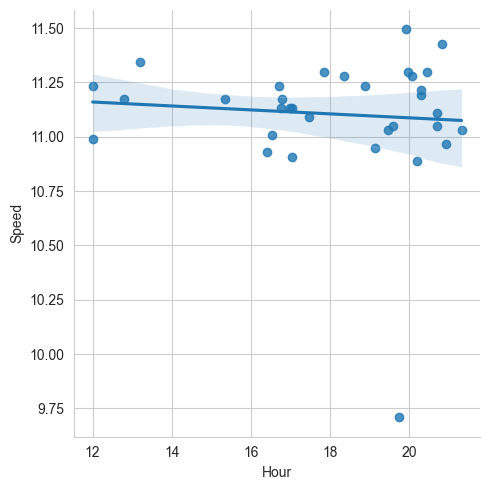

In [1630]:
scatter_speed_per_hour(winter_runs)

In [1615]:
avg_speed_for_hour_range(winter_runs)

 Avg Speed Hour Range  Runs Count
 11.428571      18-19           2
 11.342155      16-17           6
 11.278195      21-22           1
 11.194030      17-18           4
 11.029412      13-14           1
 11.029412      19-20           6
 10.968921      12-13           3
 10.948905      20-21           9
  9.708738      15-16           1


In [1616]:
avg_speed_per_day(winter_runs)

      Day  Avg Speed  Runs Count
   Sunday  10.968921           3
   Monday  11.029412           3
  Tuesday   9.708738           9
Wednesday  11.342155           3
 Thursday  11.194030           6
   Friday  11.428571           3
 Saturday  11.029412           6


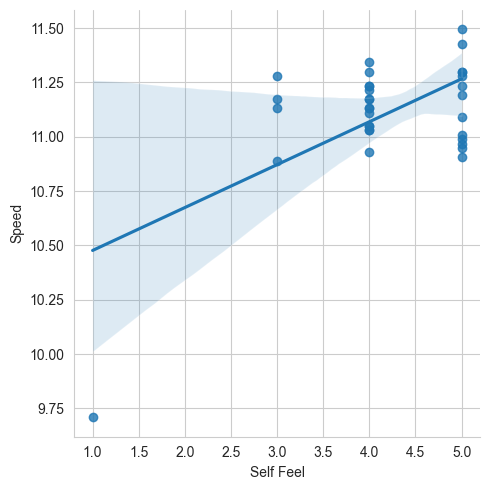

In [1617]:
scatter_speed_per_feel(winter_runs)

In [1618]:
avg_speed_per_location(winter_runs)

  Location  Avg Speed Avg Run Time  Run Count
Beer Sheva      11.03        21:20         17
 Ein Vered      10.97        20:56         11
 Traidmill       9.71        19:45          5


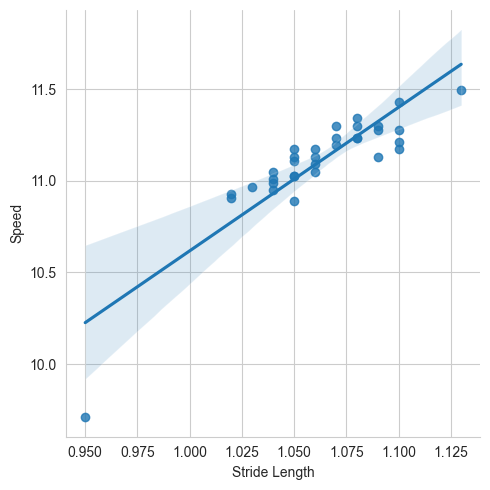

In [1619]:
scatter_speed_per_stride(winter_runs)

##### Summer Runs

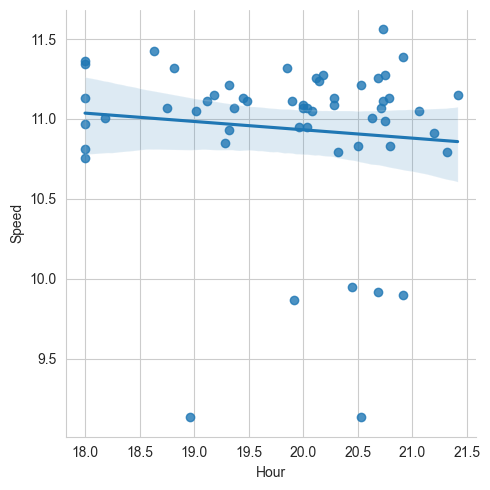

In [1620]:
scatter_speed_per_hour(summer_runs)

In [1621]:
avg_speed_for_hour_range(summer_runs)

 Avg Speed Hour Range  Runs Count
 11.152416      19-20          13
 11.152416      21-22           4
 11.131725      18-19          11
 10.909091      20-21          27


In [1622]:
avg_speed_per_day(summer_runs)

      Day  Avg Speed  Runs Count
   Sunday  11.131725           5
   Monday  11.152416          10
  Tuesday  10.909091           8
Wednesday  11.152416           6
 Thursday  11.090573          13
   Friday  10.849910           1
 Saturday  10.791367          12


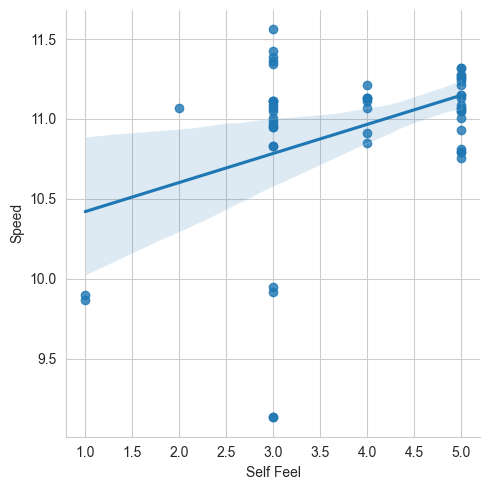

In [1623]:
scatter_speed_per_feel(summer_runs)

In [1624]:
avg_speed_per_location(summer_runs)

  Location  Avg Speed Avg Run Time  Run Count
 Ein Vered      11.15        21:25         18
Beer Sheva      11.13        19:27         32
 Traidmill      10.91        21:12          5


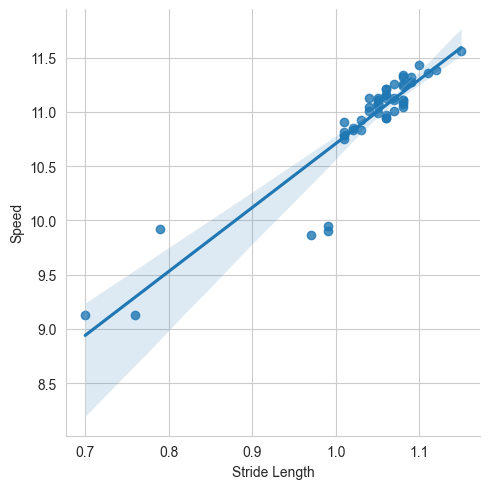

In [1625]:
scatter_speed_per_stride(summer_runs)

#### Self Feel average

##### Winter

In [1626]:
self_feel_avgs(winter_runs)

 Self Feel  Avg Effort Avg Duration  Avg HR  Avg Speed  Avg Ascent  Avg Stride Length  Run Count
         1         8.0      0:29:12   122.0      10.97        19.0               1.03          1
         3         7.0      0:28:07   122.0      11.03        22.0               1.05          4
         4        10.0      0:28:16   122.0       9.71        24.0               0.95         15
         5         8.0      0:27:40   122.0      11.34        52.0               1.08         13


In [1627]:
effort_avgs(winter_runs)

 Effort  Avg Self Feel Avg Duration  Avg HR  Avg Speed  Avg Ascent  Avg Stride Length  Run Count
      3            5.0      0:29:12   122.0      10.97        19.0               1.03          1
      4            4.0      0:28:07   122.0      11.03        22.0               1.05          3
      5            1.0      0:28:16   122.0       9.71        24.0               0.95          6
      6            4.0      0:27:40   122.0      11.34        52.0               1.08          2
      7            5.0      0:26:52   166.0      11.19        36.0               1.07          4
      8            5.0      0:27:58   171.0      11.43        32.0               1.10          4
      9            4.0      0:28:37   174.0      11.03        49.0               1.05         10
     10            5.0      0:28:31   174.0      10.95        49.0               1.04          3


##### Summer

In [1628]:
self_feel_avgs(summer_runs)

 Self Feel  Avg Effort Avg Duration  Avg HR  Avg Speed  Avg Ascent  Avg Stride Length  Run Count
         1         8.0      0:28:28   122.0      11.13        38.0               1.05          2
         2         7.0      0:29:31   122.0      11.15        35.0               1.06          1
         3        10.0      0:27:54   122.0      10.91        17.0               1.01         22
         4         9.0      0:28:19   122.0      11.15        22.0               1.06          8
         5         7.0      0:30:03   122.0      11.09        20.0               1.05         22


In [1629]:
effort_avgs(summer_runs)

 Effort  Avg Self Feel Avg Duration  Avg HR  Avg Speed  Avg Ascent  Avg Stride Length  Run Count
      4            5.0      0:28:28   122.0      11.13        38.0               1.05          2
      5            5.0      0:29:31   122.0      11.15        35.0               1.06         20
      6            4.0      0:27:54   122.0      10.91        17.0               1.01          3
      7            5.0      0:28:19   122.0      11.15        22.0               1.06          5
      8            5.0      0:30:03   122.0      11.09        20.0               1.05          7
      9            4.0      0:30:25   122.0      10.85        40.0               1.02          9
     10            5.0      0:34:46   122.0      10.79        34.0               1.01          9
